# Imports

In [ ]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import time
import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


# File upload

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Creating and Importing the dataset

In [ ]:
class FER2013Dataset(Dataset):
    """FER2013+ dataset."""

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.annotations_csv = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.annotations_csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        pixels = self.annotations_csv.iloc[idx]['pixels'].split()
        pixels = np.array(pixels, dtype=np.uint8)
        image = Image.fromarray(pixels.reshape(48,48), 'L')
        label = self.annotations_csv.iloc[idx]['class']

        if self.transform:
            image = self.transform(image)
        image= image.float()

        return image, label

Data Transforms

In [ ]:
data_transforms = transforms.Compose([
        transforms.Grayscale(3),                              
        transforms.Resize(230),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

2. Loading and splitting the data

In [ ]:
batch_size = 64
fer_train = FER2013Dataset(csv_file='/content/drive/MyDrive/fer2013p/train_b.csv', transform=data_transforms)
fer_val = FER2013Dataset(csv_file='/content/drive/MyDrive/fer2013p/valid_b.csv', transform=data_transforms)
fer_test = FER2013Dataset(csv_file='/content/drive/MyDrive/fer2013p/test_b.csv', transform=data_transforms)

dataset_sizes = {'train': len(fer_train), 'val': len(fer_val), 'test': len(fer_test) }

train_loader = torch.utils.data.DataLoader(fer_train, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(fer_val, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(fer_test, batch_size=batch_size)

class_names = {0: 'Pleasant-Active',
               1: 'Unpleasant-Active',
               2: 'Unpleasant-Unactive',
               3: 'Pleasant-Unactive'}

Show a batch of images

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485,])
    std = np.array([0.229,])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

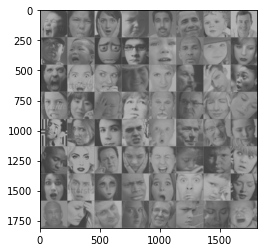

In [ ]:
# Get a batch of training data
inputs, labels = next(iter(train_loader))


# Make a grid from batch
out = utils.make_grid(inputs)

imshow(out)


# The Model

## As feature extractor

In [ ]:
model = vgg_vd_face_fer_dag(weights_path='/content/drive/MyDrive/models/vgg_vd_face_fer_dag.pth')
for param in model.parameters():
    param.requires_grad = False

model.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
model.relu5_3 = nn.ReLU()
model.pool5 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
model.fc6 = nn.Conv2d(512, 4096, kernel_size=[7, 7], stride=(1, 1))
model.relu6 = nn.ReLU()
model.fc7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
model.relu7 = nn.ReLU()
model.fc8 = nn.Linear(in_features=4096, out_features=4, bias=True)

model = model.to(device)

### Training

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

metrics = {
    'fps': BatchTimer(),
    'acc': accuracy
}

print('\n\nInitial')
print('-' * 10)
model.eval()
best_loss, met = pass_epoch(
    model, criterion, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)
best_acc = met['acc']
best_weights = copy.deepcopy(model.state_dict())
epochs = 30
for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    model.train()
    pass_epoch(
        model, criterion, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    model.eval()
    loss, mets = pass_epoch(
        model, criterion, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )
    if mets['acc'] > best_acc:
        best_acc = mets['acc']
        best_weights = copy.deepcopy(model.state_dict())
    if loss < best_loss:
        best_loss = loss


writer.close()
model.load_state_dict(best_weights)
print("best validation loss: ", best_loss)
print("best validation accuracy: ", best_acc)



Initial
----------
Valid |    63/63   | loss:    1.3861 | fps:  147.8157 | acc:    0.2629   

Epoch 1/30
----------
Train |   625/625  | loss:    1.3747 | fps:   80.8975 | acc:    0.3660   
Valid |    63/63   | loss:    1.3535 | fps:  141.4468 | acc:    0.4851   

Epoch 2/30
----------
Train |   625/625  | loss:    1.2001 | fps:   79.7227 | acc:    0.5649   
Valid |    63/63   | loss:    0.9428 | fps:  141.3900 | acc:    0.6453   

Epoch 3/30
----------
Train |   625/625  | loss:    0.7695 | fps:   79.4056 | acc:    0.6892   
Valid |    63/63   | loss:    0.6819 | fps:  139.8718 | acc:    0.7307   

Epoch 4/30
----------
Train |   625/625  | loss:    0.6015 | fps:   78.9744 | acc:    0.7645   
Valid |    63/63   | loss:    0.6187 | fps:  139.6057 | acc:    0.7490   

Epoch 5/30
----------
Train |   625/625  | loss:    0.5053 | fps:   78.9628 | acc:    0.8101   
Valid |    63/63   | loss:    0.5981 | fps:  139.4846 | acc:    0.7560   

Epoch 6/30
----------
Train |   625/625  | loss: 

### Saving the model

In [ ]:
checkpoint = {'state_dict': model.state_dict()}
torch.save(checkpoint, 'vgg16.pth')

In [ ]:
from google.colab import files
files.download("vgg16.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Testing the model

In [ ]:
test_loss = 0
acc = 0
model.eval()
start = time.time()
with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    logps = model.forward(inputs)
    batch_loss = criterion(logps, labels)
    test_loss += batch_loss.item()
                    
    ps = torch.exp(logps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    acc += torch.mean(equals.type(torch.FloatTensor)).item()
per_image = (time.time()-start)/len(test_loader)                   
print(f"Test loss: {test_loss/len(test_loader):.4f}.. "
      f"Test accuracy: {acc/len(test_loader):.4f}")

print(f"Time per frame: {per_image}")

Test loss: 0.8480.. Test accuracy: 0.7701
Time per frame: 0.1158690367426191


## By Finetuning

In [ ]:
model = vgg_vd_face_fer_dag(weights_path='/content/drive/MyDrive/models/vgg_vd_face_fer_dag.pth')
model.fc8 = nn.Linear(in_features=4096, out_features=4, bias=True)
model = model.to(device)

### Training 

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=21, gamma=0.1)

In [ ]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

metrics = {
    'fps': BatchTimer(),
    'acc': accuracy
}

print('\n\nInitial')
print('-' * 10)
model.eval()
best_loss, met = pass_epoch(
    model, criterion, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)
best_acc = met['acc']
best_weights = copy.deepcopy(model.state_dict())
epochs = 20
for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    model.train()
    pass_epoch(
        model, criterion, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    model.eval()
    loss, mets = pass_epoch(
        model, criterion, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )
    if mets['acc'] > best_acc:
        best_acc = mets['acc']
        best_weights = copy.deepcopy(model.state_dict())
    if loss < best_loss:
        best_loss = loss


writer.close()
model.load_state_dict(best_weights)
print("best validation loss: ", best_loss)
print("best validation accuracy: ", best_acc)



Initial
----------
Valid |    32/32   | loss:    1.3863 | fps:  208.7859 | acc:    0.2563   

Epoch 1/20
----------
Train |   313/313  | loss:    0.6482 | fps:   38.0501 | acc:    0.7456   
Valid |    32/32   | loss:    0.5381 | fps:  203.1018 | acc:    0.7998   

Epoch 2/20
----------
Train |   313/313  | loss:    0.3186 | fps:   38.1022 | acc:    0.9018   
Valid |    32/32   | loss:    0.5084 | fps:  208.4036 | acc:    0.8086   

Epoch 3/20
----------
Train |   313/313  | loss:    0.1979 | fps:   38.1935 | acc:    0.9538   
Valid |    32/32   | loss:    0.5037 | fps:  207.9516 | acc:    0.8145   

Epoch 4/20
----------
Train |   313/313  | loss:    0.1277 | fps:   38.1409 | acc:    0.9791   
Valid |    32/32   | loss:    0.5078 | fps:  206.3227 | acc:    0.8159   

Epoch 5/20
----------
Train |   313/313  | loss:    0.0853 | fps:   38.0884 | acc:    0.9914   
Valid |    32/32   | loss:    0.5152 | fps:  209.8590 | acc:    0.8169   

Epoch 6/20
----------
Train |   313/313  | loss: 

### Saving the model

In [ ]:
checkpoint = {'state_dict': model.state_dict()}

torch.save(checkpoint, 'vgg16_fin.pth')

### Testing

In [ ]:
model = vgg_m_face_bn_fer_dag()
model.fc8 = nn.Linear(in_features=4096, out_features=4, bias=True)

st = torch.load('/content/drive/MyDrive/Models FER2013+/vgg16.pth')
model.load_state_dict(st['state_dict'])

model = model.to(device)

In [ ]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

metrics = {
    'fps': BatchTimer(),
    'acc': accuracy
}

print('\n\nInitial')
print('-' * 10)
model.eval()
best_loss, met = pass_epoch(
    model, criterion, test_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)




Initial
----------
Valid |    28/28   | loss:    0.6565 | fps:  209.6032 | acc:    0.7844   


In [ ]:
from sklearn import metrics as m

model.eval()
outputs_all = []
labels_all = []
outs = []
with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    logps = model.forward(inputs)
    ps = torch.exp(logps)
    top_p, top_class = ps.topk(1, dim=1)
    labels_all = labels_all + labels.tolist()
    outputs_all = outputs_all + top_class.tolist()
    outs = outs + logps.tolist()
    
report = m.classification_report(labels_all,outputs_all)
cm = m.confusion_matrix(labels_all,outputs_all)

print(report)
print(cm)

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       441
           1       0.82      0.81      0.81       441
           2       0.74      0.69      0.72       441
           3       0.71      0.78      0.74       441

    accuracy                           0.79      1764
   macro avg       0.79      0.79      0.79      1764
weighted avg       0.79      0.79      0.79      1764

[[381  27  10  23]
 [ 25 358  29  29]
 [ 13  37 305  86]
 [ 15  17  66 343]]


# Model Definition

In [ ]:
class Vgg_vd_face_fer_dag(nn.Module):

    def __init__(self):
        super(Vgg_vd_face_fer_dag, self).__init__()
        self.meta = {'mean': [129.186279296875, 104.76238250732422, 93.59396362304688],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_3 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_2 = nn.ReLU()
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_3 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.fc6 = nn.Conv2d(512, 4096, kernel_size=[7, 7], stride=(1, 1))
        self.relu6 = nn.ReLU()
        self.fc7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(in_features=4096, out_features=7, bias=True)

    def forward(self, data):
        x1 = self.conv1_1(data)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31 = self.pool5(x30)
        x32 = self.fc6(x31)
        x33_preflatten = self.relu6(x32)
        x33 = x33_preflatten.view(x33_preflatten.size(0), -1)
        x34 = self.fc7(x33)
        x35 = self.relu7(x34)
        prediction = self.fc8(x35)
        return prediction

def vgg_vd_face_fer_dag(weights_path=None, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Vgg_vd_face_fer_dag()
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model


# Helper Methods

In [ ]:
class BatchTimer(object):
    """Batch timing class.
    Use this class for tracking training and testing time/rate per batch or per sample.
    
    Keyword Arguments:
        rate {bool} -- Whether to report a rate (batches or samples per second) or a time (seconds
            per batch or sample). (default: {True})
        per_sample {bool} -- Whether to report times or rates per sample or per batch.
            (default: {True})
    """

    def __init__(self, rate=True, per_sample=True):
        self.start = time.time()
        self.end = None
        self.rate = rate
        self.per_sample = per_sample

    def __call__(self, y_pred, y):
        self.end = time.time()
        elapsed = self.end - self.start
        self.start = self.end
        self.end = None

        if self.per_sample:
            elapsed /= len(y_pred)
        if self.rate:
            elapsed = 1 / elapsed

        return torch.tensor(elapsed)

In [ ]:
class Logger(object):

    def __init__(self, mode, length, calculate_mean=False):
        self.mode = mode
        self.length = length
        self.calculate_mean = calculate_mean
        if self.calculate_mean:
            self.fn = lambda x, i: x / (i + 1)
        else:
            self.fn = lambda x, i: x

    def __call__(self, loss, metrics, i):
        track_str = '\r{} | {:5d}/{:<5d}| '.format(self.mode, i + 1, self.length)
        loss_str = 'loss: {:9.4f} | '.format(self.fn(loss, i))
        metric_str = ' | '.join('{}: {:9.4f}'.format(k, self.fn(v, i)) for k, v in metrics.items())
        print(track_str + loss_str + metric_str + '   ', end='')
        if i + 1 == self.length:
            print('')

In [ ]:
 def pass_epoch(
    model, loss_fn, loader, optimizer=None, scheduler=None,
    batch_metrics={'time': BatchTimer()}, show_running=True,
    device='cpu', writer=None
):   

    mode = 'Train' if model.training else 'Valid'
    logger = Logger(mode, length=len(loader), calculate_mean=show_running)
    loss = 0
    metrics = {}


    for i_batch, (x, y) in enumerate(loader):
        x = x.float().to(device)
        y = y.long().to(device)
        y_pred = model(x)
        loss_batch = loss_fn(y_pred, y)

        if model.training:
            loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()

        metrics_batch = {}
        for metric_name, metric_fn in batch_metrics.items():
            metrics_batch[metric_name] = metric_fn(y_pred, y).detach().cpu()
            metrics[metric_name] = metrics.get(metric_name, 0) + metrics_batch[metric_name]
            
        if writer is not None and model.training:
            if writer.iteration % writer.interval == 0:
                writer.add_scalars('loss', {mode: loss_batch.detach().cpu()}, writer.iteration)
                for metric_name, metric_batch in metrics_batch.items():
                    writer.add_scalars(metric_name, {mode: metric_batch}, writer.iteration)
            writer.iteration += 1
        
        loss_batch = loss_batch.detach().cpu()
        loss += loss_batch
        if show_running:
            logger(loss, metrics, i_batch)
        else:
            logger(loss_batch, metrics_batch, i_batch)
    
    if model.training and scheduler is not None:
        scheduler.step()

    loss = loss / (i_batch + 1)
    metrics = {k: v / (i_batch + 1) for k, v in metrics.items()}
            
    if writer is not None and not model.training:
        writer.add_scalars('loss', {mode: loss.detach()}, writer.iteration)
        for metric_name, metric in metrics.items():
            writer.add_scalars(metric_name, {mode: metric})

    return loss, metrics

In [ ]:
def accuracy(logits, y):
    _, preds = torch.max(logits, 1)
    return (preds == y).float().mean()